In [1]:
import numpy as np
from time import perf_counter
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

#### Funkcje generujące macierze do układów równań

In [2]:
def random_matrix_size_n(n):
    return [[np.float32(np.random.uniform(0, 500)) for _ in range(n)] for _ in range(n)]


def random_vector_size_n(n):
    return [np.float32(np.random.uniform(0, 500)) for _ in range(n)]


def euclid_dist(v1, v2):
    return np.sqrt(sum([pow(v1[i] - v2[i], 2) for i in range(len(v1))]))

## Zad 1. Metoda Gaussa-Jordana

### Funkcja do przeskalowania macierzy

In [3]:
def scale_the_matrix(A, B):
    n = len(A)
    for i in range(n):
        best = max(max(A[i]), B[i], abs(min(A[i])))
        for j in range(n):
            A[i][j] /= best
        B[i] /= best


#### Standardowy Gauss-Jordan

In [4]:
def gauss_jordan(A, B, scale=False):
    if scale:
        scale_the_matrix(A, B)
    n = len(A)
    for i in range(n):
        for j in range(n):
            if i != j:
                multiplier = A[j][i] / A[i][i]
                for k in range(i, n):
                    A[j][k] -= multiplier*A[i][k]
                B[j] -= multiplier*B[i]

    for i in range(n):
        B[i] /= A[i][i]
    return B

#### Gauss-Jordan z częsciowym poszukiwaniem elementu wiodącego
W tej wersji wiersze macierzy mogły się między sobą zamieniać, więc użyłem tablicy "perm", aby śledzić kolejne zamiany i na końcu odtworzyć poprawną
kolejność elementów w wektorze wynikowym

In [5]:
def gauss_jordan_partial_pivoting(A, B, scale=False):
    if scale:
        scale_the_matrix(A, B)
    n = len(A)
    perm = [i for i in range(n)]
    for i in range(n):
        pivot = i
        for j in range(i + 1, n):
            if abs(A[perm[pivot]][i]) < abs(A[perm[j]][i]):
                pivot = j

        perm[pivot], perm[i] = perm[i], perm[pivot]
        for j in range(n):
            if i != j:
                multiplier = A[perm[j]][i] / A[perm[i]][i]
                for k in range(i, n):
                    A[perm[j]][k] -= multiplier*A[perm[i]][k]
                B[perm[j]] -= multiplier*B[perm[i]]

    for i in range(n):
        B[perm[i]] /= A[perm[i]][i]

    ans = [0 for _ in range(n)]
    for i in range(n):
        ans[i] = B[perm[i]]
    return ans

#### Gauss-Jordan z całkowitym poszukiwaniem elementu wiodącego
Teraz między sobą mogły zamieniać się też kolumny macierzy, więc użyłem dwóch tablic permutacji odzielnie do wierzy i kolumn

In [6]:
def gauss_jordan_complete_pivoting(A, B, scale=False):
    if scale:
        scale_the_matrix(A, B)
    n = len(A)
    perm_r = [i for i in range(n)]
    perm_c = perm_r[:]
    for i in range(n):
        pivot_r = i
        pivot_c = i
        for j in range(i, n):
            for k in range(i, n):
                if abs(A[perm_r[pivot_r]][perm_c[pivot_c]]) < abs(A[perm_r[j]][perm_c[k]]):
                    pivot_r = j
                    pivot_c = k

        perm_r[pivot_r], perm_r[i] = perm_r[i], perm_r[pivot_r]
        perm_c[pivot_c], perm_c[i] = perm_c[i], perm_c[pivot_c]

        for j in range(n):
            if i != j:
                multiplier = A[perm_r[j]][perm_c[i]] / A[perm_r[i]][perm_c[i]]
                for k in range(i, n):
                    A[perm_r[j]][perm_c[k]] -= multiplier*A[perm_r[i]][perm_c[k]]
                B[perm_r[j]] -= multiplier*B[perm_r[i]]

    for i in range(n):
        B[perm_r[i]] /= A[perm_r[i]][perm_c[i]]

    ans = [0 for _ in range(n)]
    for i in range(n):
        ans[perm_c[i]] = B[perm_r[i]]
    return ans

## Porównanie czasów działania

In [14]:
def time(func, *args, **kwargs):
    start = perf_counter()
    func(*args, **kwargs)
    end = perf_counter()
    return end - start

In [ ]:
sizes = [10, 20, 50, 100, 200, 250, 300, 350, 400, 450, 500, 520, 550, 570, 600]
library_time = []
gauss_jordan_time = []
gauss_jordan_partial_pivoting_time = []
gauss_jordan_complete_pivoting_time = []
for size in sizes:
    A1 = random_matrix_size_n(size)
    B1 = random_vector_size_n(size)

    A2 = deepcopy(A1)
    B2 = deepcopy(B1)
    A3 = deepcopy(A1)
    B3 = deepcopy(B1)

    A4 = np.array(A1)
    B4 = np.array(B1)

    library_time.append(time(np.linalg.solve, A4, B4))
    gauss_jordan_time.append(time(gauss_jordan, A1, B1))
    gauss_jordan_partial_pivoting_time.append(time(gauss_jordan_partial_pivoting, A2, B2))
    gauss_jordan_complete_pivoting_time.append(time(gauss_jordan_complete_pivoting, A3, B3))


In [84]:
df = pd.DataFrame(data=[
    np.round(library_time, 3),
    np.round(gauss_jordan_time, 3),
    np.round(gauss_jordan_partial_pivoting_time, 3),
    np.round(gauss_jordan_complete_pivoting_time, 3)],
    columns=sizes,
    index=['Numpy', 'Simple Gauss-Jordan', 'Partial Pivoting', 'Complete Pivoting'])
df

,10,20,50,100,200,250,300,350,400,450,500,520,550,570,600
Numpy,0.0,0.000,0.000,0.001,0.002,0.005,0.005,0.006,0.003,0.005,0.009,0.005,0.008,0.006,0.007
Simple Gauss-Jordan,0.0,0.001,0.014,0.101,0.844,1.772,3.214,4.821,7.200,10.366,14.710,15.397,19.691,19.819,23.382
Partial Pivoting,0.0,0.001,0.015,0.118,1.030,1.824,3.392,5.600,8.369,12.124,17.098,17.788,20.688,23.138,26.892
Complete Pivoting,0.0,0.002,0.034,0.201,1.709,3.643,6.308,9.997,15.433,23.142,28.219,32.697,37.761,42.573,49.957


Tabela powyżej przedstawia ile czasu w sekundach( zaokrąglone do 0.001) zajęło znalezienie rozwiązania dla danego rozmiaru macierzy i konkretnego algorytmu

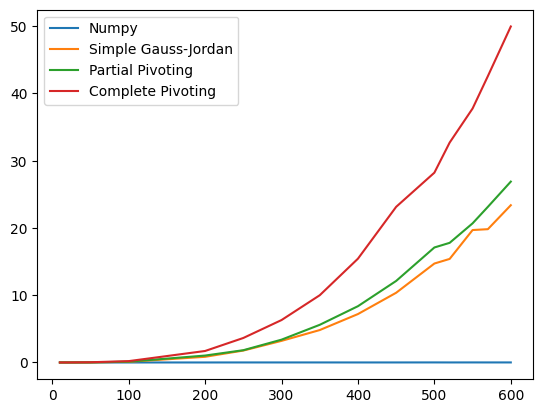

In [85]:
plt.plot(sizes, library_time, label = "Numpy")
plt.plot(sizes, gauss_jordan_time, label = "Simple Gauss-Jordan")
plt.plot(sizes,  gauss_jordan_partial_pivoting_time, label = "Partial Pivoting")
plt.plot(sizes, gauss_jordan_complete_pivoting_time, label = "Complete Pivoting")
plt.legend()
plt.show()

Te same dane co w tabeli, lecz w postaci wykresu.
Widać, że implementacje operujące na pythonowych listach są dużo wolniejsze od funkcji z biblioteki numpy.
Pozostałe wyniki zgadzają się oczekiwaniami. Partial pivoting w odróżnieniu do klasycznego Gaussa-Jordana w każdej n razy szuka pivota spośród n dostępnych,
więc w porówaniu do standardowego algorytmu wykonuje O(n^2) dodatkowej pracy, lecz skoro algorytm ma złożoność sześcienną nie widać znacznej różnicy w czasie.
Inaczej to wygląda w przypadku complete-pivoting. W n iteracjach szukamy nowego pivota w całej macierzy, co kosztuje miej więcej tyle samo co następująca potem elminacje kolejnych wierszy z użyciem tego pivota. Jak widać po wynikach przedstawionych w tabeli, a także na wykresie, complete pivoting ma około dwa razy większą stałą co pozostałe dwa algorytmy

## Porównanie dokładności wyników

Jako miarę dokładności uzyskanego wyniku przyjąłem odległość euklidesową wektora zwróconego przez dany algorytm od wyników uzyskanych przy użyciu funkcji do numpy.linalg.solve. Dla danej wielkości macierzy przeprowadziłem po kilkadziesiąt różnych testów( dla większych macierzy mniej) i zliczyłem ile razy procentowo dany algorytm okazał się najdokładniejszy

In [ ]:
tests = [(10, 100), (20, 100), (40, 100), (50, 100), (80, 50), (100, 30), (150, 30), (200, 30)]
count = [[0 for _ in range(3)] for _ in range(len(tests))]
functions = [(gauss_jordan, 0), (gauss_jordan_partial_pivoting, 1), (gauss_jordan_complete_pivoting, 2)]

for index, (size, no_of_tests) in enumerate(tests):
    for _ in range(no_of_tests):
        A1 = random_matrix_size_n(size)
        B1 = random_vector_size_n(size)

        numpy_vector = np.linalg.solve(A1, B1)
        best = float("inf")
        best_id = 0
        for f, f_id in functions:
            A2 = deepcopy(A1)
            B2 = deepcopy(B1)
            vect = f(A2, B2)
            dist = euclid_dist(numpy_vector, vect)
            if dist < best:
                best = dist
                best_id = f_id

        count[index][best_id] += 1


In [110]:
t1, t2, t3 = [], [], []
for row in count:
    count_all = sum(row)
    t1.append(row[0] / count_all)
    t2.append(row[1] / count_all)
    t3.append(row[2] / count_all)

test_sizes = [a for a, b in tests]
df = pd.DataFrame(data=[
    np.round(t1, 3),
    np.round(t2, 3),
    np.round(t3, 3)],
    columns=test_sizes,
    index=['Simple Gauss-Jordan', 'Partial Pivoting', 'Complete Pivoting'])
df

,10,20,40,50,80,100,150,200
Simple Gauss-Jordan,0.01,0.00,0.00,0.00,0.00,0.0,0.000,0.0
Partial Pivoting,0.45,0.39,0.42,0.42,0.28,0.3,0.433,0.3
Complete Pivoting,0.54,0.61,0.58,0.58,0.72,0.7,0.567,0.7


Wartości w pierwszym wierszu to wymiar macierzy, wartości w tabeli oznaczają w iluprocentach przypadków najlepszy okazał się dany algorytm

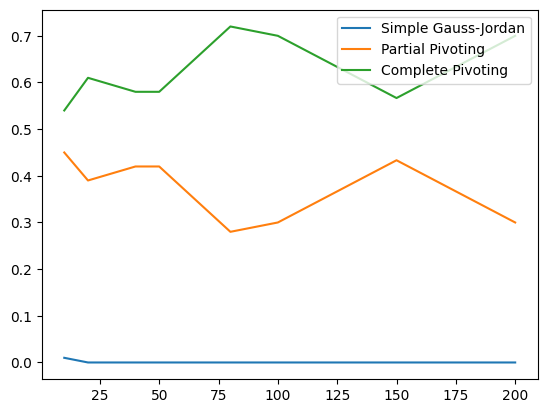

In [111]:
plt.plot(test_sizes, t1, label = "Simple Gauss-Jordan")
plt.plot(test_sizes,  t2, label = "Partial Pivoting")
plt.plot(test_sizes, t3, label = "Complete Pivoting")
plt.legend()
plt.show()

Zgodnie z oczekiwaniami, zwykły Gauss-Jordan okazał się być bardzo niedokładny, a najlepszy w aspekcie dokładności numerycznej jest algorytm wykorzystujacy complete - pivoting.

## Zad 2. Dekompozycja LU

Algorytm działa w miejscu, elementy obu macierzy( L i U) są zapisywane w danej macierzy A, ponadto wiadomo, że na głównej przekątanej macierzy L
są same jedynki.

In [11]:
def lu_decomposition_in_situ(A):
    n = len(A)
    for i in range(n - 1):
        for j in range(i + 1, n):
            multiplier = A[j][i] / A[i][i]
            A[j][i] = multiplier
            for k in range(i + 1, n):
                A[j][k] -= multiplier*A[i][k]
    return A

Funkcja wymnaża macierze L i U, a następnie oblicza odległość macierzy A, która była początkową macierzą od macierzy L razy U (odległość w tym przypadku to norma Frobeniusa z różnicy dwóch macierzy). Jako, że obie zapisane w jednej macierzy algorytm wymnażania jest zaimplementowany trochę inaczej

In [12]:
def compute_lu_distance(A, LU):
    C = np.zeros((len(A), len(A)))
    n = len(A)
    norm = 0
    for i in range(n):
        for j in range(n):
            entry = 0
            if i == j:
                for k in range(i):
                    entry += LU[i][k] * LU[k][i]
                entry += LU[i][i]
            elif i < j:
                for k in range(i):
                    entry += LU[i][k]*LU[k][j]
                entry += LU[i][j]
            else:
                for k in range(j + 1):
                    entry += LU[i][k]*LU[k][j]
            C[i][j] = entry
            norm += pow(A[i][j] - entry, 2)
    return np.sqrt(norm)

In [ ]:
matrix_distance = []
t_sizes = [10, 20, 30, 50, 100, 200, 250, 300, 350, 400, 450, 500]
for size in t_sizes:
    A = random_matrix_size_n(size)
    A_copy = deepcopy(A) # żeby potem dało się obliczyć normę frobeniusa
    lu_decomposition_in_situ(A)
    matrix_distance.append(compute_lu_distance(A_copy, A))

In [41]:
df = pd.DataFrame(data=[np.round(matrix_distance, 3)],
    columns=t_sizes,
    index=['Matrix Distance'])
df

,10,20,30,50,100,200,250,300,350,400,450,500
Matrix Distance,0.001,0.002,0.005,0.021,0.115,0.911,2.18,18.891,3.821,96.26,2.871,64.362


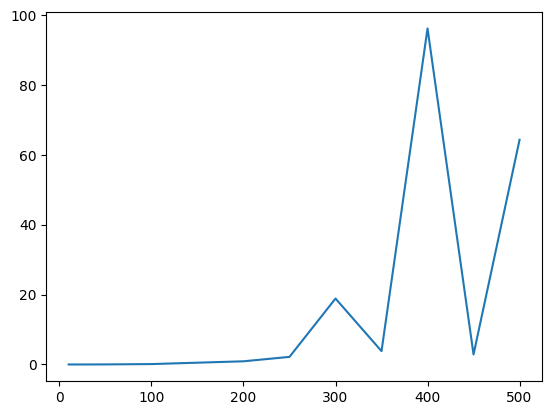

In [43]:
plt.plot(t_sizes, matrix_distance)
plt.show()

Na niedokładność tych obliczeń składała się zarówno niedokładność przy procesie elminacji, a także poźniejsze wymnażanie. Widać, że rozbieżność mogła być bardzo duża
